In [39]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Define couopled ODE for Cash-Karp

In [40]:
def dfdx(x,f):
    
    # d^2y/dx^2, define
    # y = f[0], dy/dx = z, z = f[1]
    
    y = f[0]
    z = f[1]
    
    # Return derivs
    dydx = np.zeros_like(f)
    dydx[0] = z
    dydx[1] = -1*y
    
    return dydx

## Cash-Karp Core

In [41]:
def ck_core_mv(x_i, y_i, nv, h, f):
    
    # Cash Karp defined in terms of weighting variables
    ni = 7
    nj = 6
    ci = np.zeros(ni)
    aij = np.zeros((ni, nj))
    bi = np.zeros(ni)
    bis = np.zeros(ni)
    
    # Input values for ci, aij, bi and bis
    ci[2] = 1./5.
    ci[3] = 3./10.
    ci[4] = 3./5.
    ci[5] = 1.
    ci[6] = 7./8.
    
    # j = 1
    aij[2,1] = 1./5.
    aij[3,1] = 3./40.
    aij[4,1] = 3./10.
    aij[5,1] = -11./54.
    aij[6,1] = 1631./55296.
    
    # j = 2
    aij[3,2] = 9./40.
    aij[4,2] = -9./10.
    aij[5,2] = 5./2.
    aij[6,2] = 175./512.
    
    # j = 3
    aij[4,3] = 6./5.
    aij[5,3] = -70./27.
    aij[6,3] = 575./13824.
    
    # j = 4
    aij[5,4] = 35./27.
    aij[6,4] = 44275./110592.
    
    # j = 5
    aij[6,5] = 253./4096.
    
    # bi
    bi[1] = 37./378.
    bi[2] = 0.
    bi[3] = 250./621.
    bi[4] = 125./594.
    bi[5] = 0.0
    bi[6] = 512./1771.
    
    # bis
    bis[1] = 2825./27648.
    bis[2] = 0.0
    bis[3] = 18575./48384.
    bis[4] = 13525./55296.
    bis[5] = 277./14336.
    bis[6] = 1./4.
    
    # Define k array
    ki = np.zeros((ni, nv))
    
    # Compute ki
    for i in range(1,ni):
        
        # Compute xn+1 for i
        xn = x_i + ci[i]*h
        
        # Compute temporary y
        yn = y_i.copy()
        for j in range(1,i):
            yn += aij[i,j]*ki[j,:]
            
        # Get k
        ki[i,:] = h*f(xn,yn)
        
    # Get ynpo, ynpo*
    ynpo = y_i.copy()
    ynpos = y_i.copy()
    
    # print("ni = ", ni, ynpo, ynpos)
    
    for i in range(1,ni):
        ynpo += bi[i]*ki[i,:]
        ynpos += bis[i]*ki[i,:]
        
    # Get error
    Delta = np.fabs(ynpo - ynpos)
    
    # print("INSIDE Delta", Delta, ki[:,0], ynpo, ynpos)
    
    # Return new y and Delta
    return ynpo, Delta


## Adaptive Step Size Driver

In [45]:
def ck_mv_ad(dfdx, x_i, y_i, nv, h, tol):
    
    # Define safety scale
    SAFETY = 0.9
    H_NEW_FAC = 2.0
    
    # Set max # of iterations
    imax = 1000
    
    # Set iteration variable
    i = 0
    
    # Create error
    Delta = np.full(nv, 2*tol)
    
    # Remember step
    h_step = h
    
    # Adjust the step
    while(Delta.max()/tol > 1.0):
        
        # Get new y and error estimate
        y_ipo, Delta = ck_core_mv(x_i, y_i, nv, h_step, dfdx)
        
        # If error too large, take smaller step
        if(Delta.max()/tol > 1.0):
            
            # Error too large, decrease step
            h_step *= SAFETY*(Delta.max()/tol)**(-0.25)
            
        # Check iteration
        if(i >= imax):
            print("Too many iterations in ck_mv_ad()")
            raise StopIteration("Ending after i = ", i)
            
        # Iterate
        i += 1
        
    # Next time, try bigger step
    h_new = np.fmin(h_step*(Delta.max()/tol)**(-0.9), h_step*H_NEW_FAC)
    
    # Return answer and step info
    return y_ipo, h_new, h_step

In [43]:
def ck_mv(dfdx, a, b, y_a, tol, verbose = False):
    
    # dfdx is deriv wrt x, a is lower bound, b is upper bound
    # y_a are boundary conditions at a, tol is tolerance
    
    # Define starting step
    xi = a
    yi = y_a.copy()
    
    # Define initial starting step
    h =  1.0e-4*(b-a)
    
    # Set max # iterations and iteration variable
    imax = 1000
    i = 0
    
    # number of variables
    nv = len(y_a)
    
    # Set initial conditions
    x = np.full(1,a)
    y = np.full((1,nv), y_a)
    
    # Set flag
    flag = True
    
    # Loop till upper bound b reached
    while(flag):
        
        # Calculate y_i+1, step info
        y_ipo, h_new, h_step = ck_mv_ad(dfdx, xi, yi, nv, h, tol)
        
        # Update step for next time
        h = h_new
        
        # Prevent overshoot of upper bound
        if(xi+h_step > b):
            
            # Limit step to end at b
            h = b - xi
            
            # Recompute y_i+1
            y_ipo, h_new, h_step = ck_mv_ad(dfdx, xi, yi, nv, h, tol)
            
            # Done
            flag = False
            
        # Update values
        xi += h_step
        yi = y_ipo.copy()
        
        # Add the step
        x = np.append(x, xi)
        y_ipo = np.zeros((len(x), nv))
        y_ipo[0:len(x)-1,:] = y[:]
        y_ipo[-1,:] = yi[:]
        del y
        y = y_ipo
        
        # Prevent too many iterations
        if(i > imax):
            print("Maximum iterations reached.")
            raise StopIteration("Iteration number = ", i)
            
        # Iterate
        i += 1
        
        # Output some info
        if(verbose):
            s = "i = %3d\tx = %9.8f\ty = %9.8f\th = %9.8f\tb = %9.8f" % (i, xi, yi[0], h_step, b)
            print(s)
            
        # If finished, exit
        if(xi == b):
            flag = False
            
    # Return answer
    return x, y

## Wrapper

i =   1	x = 0.00062832	y = 0.00062832	h = 0.00062832	b = 6.28318531
i =   2	x = 0.00188496	y = 0.00188495	h = 0.00125664	b = 6.28318531
i =   3	x = 0.00439823	y = 0.00439822	h = 0.00251327	b = 6.28318531
i =   4	x = 0.00942478	y = 0.00942464	h = 0.00502655	b = 6.28318531
i =   5	x = 0.01947787	y = 0.01947664	h = 0.01005310	b = 6.28318531
i =   6	x = 0.03958407	y = 0.03957373	h = 0.02010619	b = 6.28318531
i =   7	x = 0.07979645	y = 0.07971180	h = 0.04021239	b = 6.28318531
i =   8	x = 0.16022123	y = 0.15953660	h = 0.08042477	b = 6.28318531
i =   9	x = 0.32107077	y = 0.31558279	h = 0.16084954	b = 6.28318531
i =  10	x = 0.64276986	y = 0.59941495	h = 0.32169909	b = 6.28318531
i =  11	x = 0.93739384	y = 0.80601851	h = 0.29462398	b = 6.28318531
i =  12	x = 1.20675386	y = 0.93446544	h = 0.26936002	b = 6.28318531
i =  13	x = 1.49426997	y = 0.99707369	h = 0.28751611	b = 6.28318531
i =  14	x = 1.76344767	y = 0.98150050	h = 0.26917769	b = 6.28318531
i =  15	x = 2.03076151	y = 0.89606839	h = 0.2673

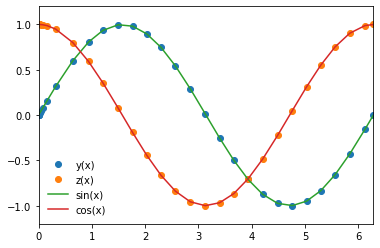

In [44]:
a = 0.0
b = 2.0*np.pi
y_0 = np.zeros(2)
y_0[0] = 0.0
y_0[1] = 1.0
nv = 2

tolerance = 1.0e-6
x, y = ck_mv(dfdx, a, b, y_0, tolerance, verbose = True)
plt.plot(x, y[:,0], 'o', label = 'y(x)')
plt.plot(x, y[:,1], 'o', label = 'z(x)')
plt.plot(x, np.sin(x), label = 'sin(x)')
plt.plot(x, np.cos(x), label = 'cos(x)')
plt.xlim([0, 2*np.pi])
plt.ylim([-1.2, 1.2])
plt.legend(frameon = False)